In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

import time
import datetime

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
df = pd.read_csv('Source/flipkart_com-ecommerce_sample_1050.csv',sep=',')

In [4]:
path_img = 'Source/Images'

In [5]:
df.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [6]:
# lire des caractère sur une image
import nltk
nltk.download('punkt')
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = np.array(df.product_category_tree)

token = [tokenizer.tokenize(i.lower()) for i in token]

bigram = [list(nltk.bigrams(bigram)) for bigram in token]

token_bigram = pd.Series(bigram)

cat_name = np.array([token_bigram[i][0] for i in range(len(token_bigram))])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dragomir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 + ' ' +  df_token.cat2

In [8]:
df['category_name'] = df_token

In [9]:
from sklearn import preprocessing


# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home furnishing       150
baby care             150
home decor            150
kitchen dining        150
beauty and            150
watches wrist         149
computers laptop       87
computers network      49
computers computer      6
computers tablet        3
computers storage       2
computers laptops       2
computers software      1
watches clocks          1
Name: category_name, dtype: int64

In [153]:
df_token = pd.DataFrame(cat_name, columns=['cat1','cat2'])
df_token = df_token.cat1 
df['category_name'] = df_token
# preprocessing encodage des données
encodage = preprocessing.LabelEncoder()
encodage.fit(df.category_name)
df["label"] = encodage.transform(df.category_name)
# data.head(5)
df.category_name.value_counts()

home         300
baby         150
watches      150
kitchen      150
beauty       150
computers    150
Name: category_name, dtype: int64

In [154]:
img = [img for img in df.image]
img_path = []

for i in range(len(img)):
    img_path.append(path_img+"/"+img[i])
    df['path_img'] = path_img+"/"+img[i]

In [155]:
img_path[1]

'Source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg'

### Extraction de features avec SIFT

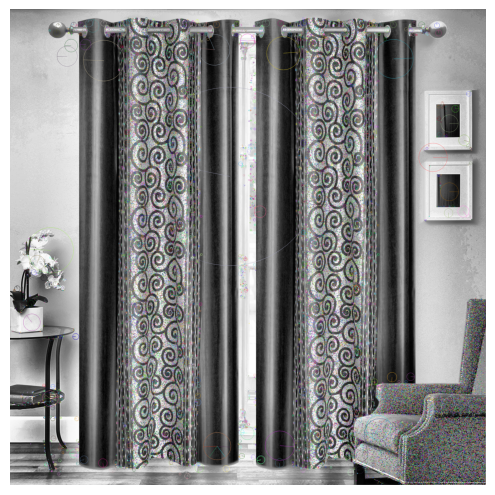

Text(0.5, 1.0, 'Adaptive equalization')

In [356]:
# egalizateur de contraste

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img = axes
    #ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    
    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
# Display results
fig = plt.figure(figsize=(8, 5))
axes = plt.subplot()
plot_img_and_hist(img_adapteq, axes)
ax_img.set_title('Adaptive equalization')

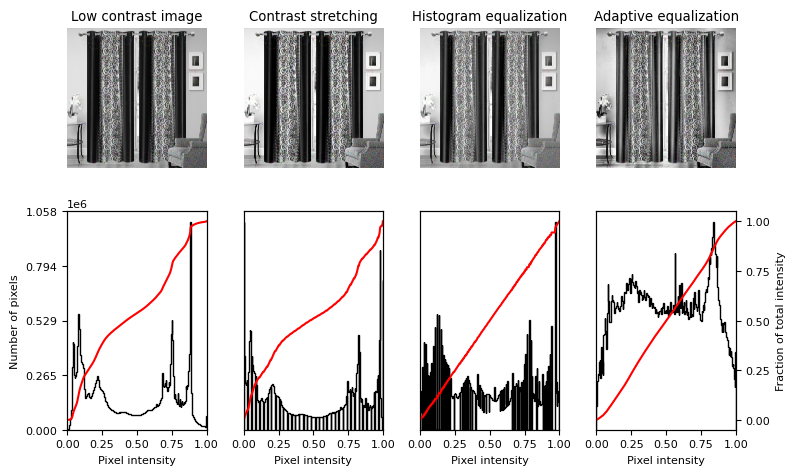

In [182]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image


# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
pixel1 = image_descripteur_org[0][8]
pix = pixel1.reshape(16,8)
plt.imshow(pix)

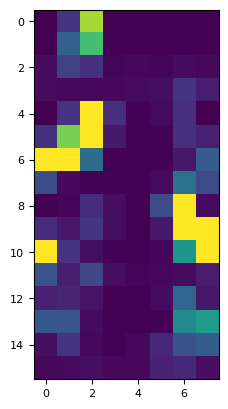

In [308]:
pixel1 = image_descripteur_org[0][8]
pix = pixel1.reshape(16,8)
plt.imshow(pix)

In [271]:
df.loc[df.label == 2].index

Int64Index([  47,   51,   53,   54,   55,   87,  115,  119,  122,  296,
            ...
            1019, 1021, 1023, 1024, 1025, 1028, 1032, 1034, 1035, 1036],
           dtype='int64', length=150)

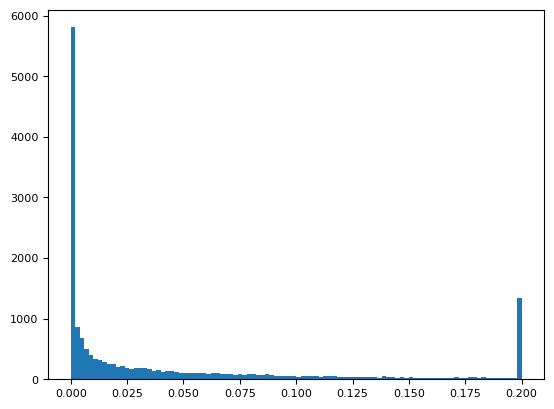

In [277]:
plt.hist(image_descripteur[47].flatten(),bins= 100)
plt.show()

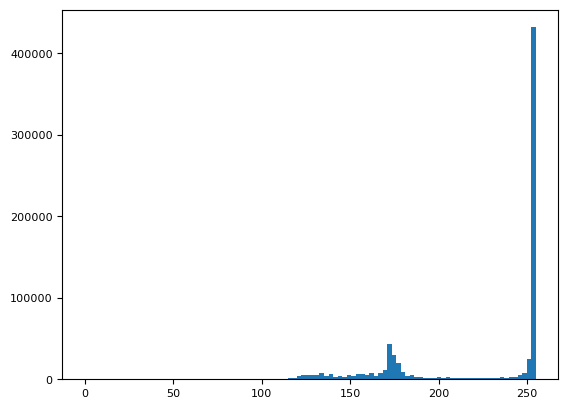

In [287]:
plt.hist(image_features[53].flatten(),bins=100)
plt.show()


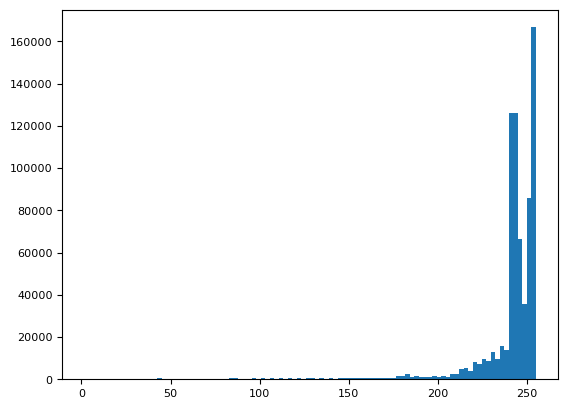

In [288]:
plt.hist(image_features[47].flatten(),bins=100)
plt.show()


In [372]:
img_.shape

(3600, 3600, 3)

In [373]:
img_adapteq.shape

(3600, 3600, 3)

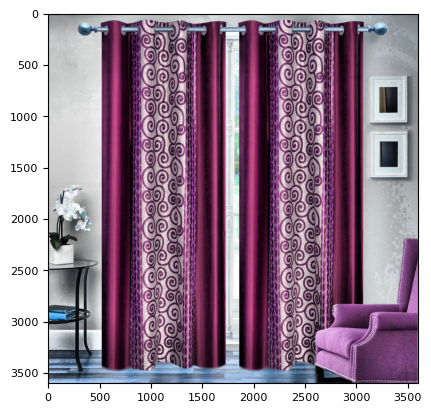

In [369]:
img_adapteq = exposure.equalize_adapthist(img_, clip_limit=0.03)
plt.imshow(img_adapteq)

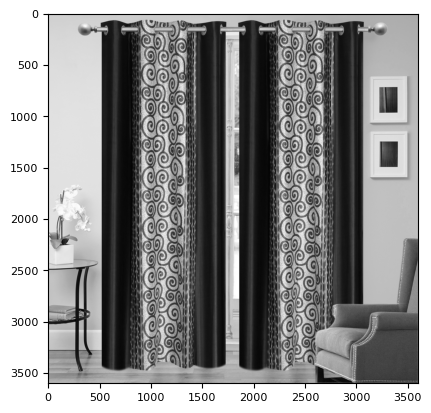

In [427]:
gray= cv2.cvtColor(img_,cv2.COLOR_GRAY2BGR)
plt.imshow(gray)

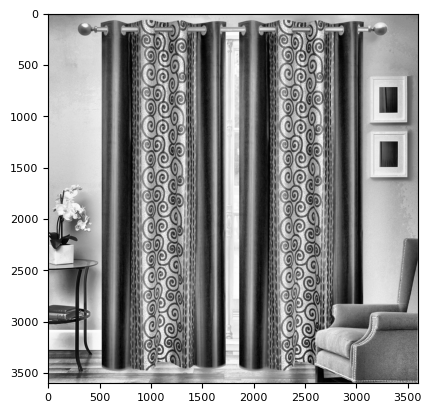

In [439]:
# Important NOTE: Use opencv <= 3.4.2.16 as
# SIFT is no longer available in
# opencv > 3.4.2.16
import cv2

time1 = time.time()

# Loading the image
img_ = cv2.imread(img_path[0],cv2.IMREAD_GRAYSCALE)

img_adapteq = exposure.equalize_adapthist(img_, clip_limit=0.03)

# Convertir l'image en uint8 (CV_8U)
img_adapteq_uint8 = (img_adapteq * 255).astype('uint8')

# Converting image to grayscale
gray= cv2.cvtColor(img_adapteq_uint8,cv2.COLOR_GRAY2BGR)

plt.imshow(gray)

# Applying SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
keyp , descript = sift.detectAndCompute(gray,None)

try:
    descripteurs_norm = np.linalg.norm(descript, axis=1, keepdims=True)
    descripteurs_normalises = descript / descripteurs_norm
except : 
    #descripteurs_normalises = 0
    descripteurs_norm = 0
    descripteurs_normalises = descripteurs / descripteurs_norm
# Seuillage des valeurs des vecteurs de descripteurs
seuil = 0.2
descripteurs_seuilles = np.minimum(descripteurs_normalises, seuil)

# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      keyp ,
                      img_adapteq ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

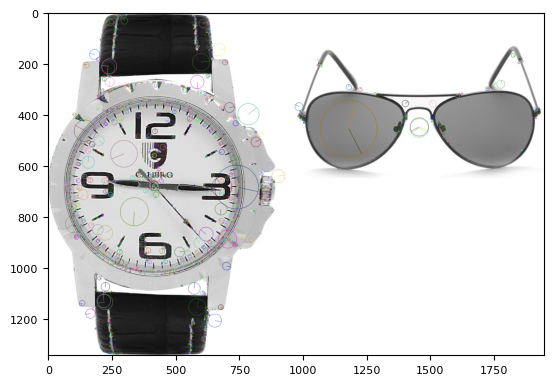

In [438]:
# Convertir l'image en uint8 (CV_8U)
plt.imshow(img)

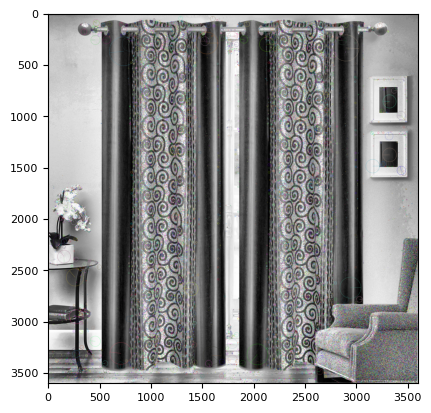

In [440]:
plt.imshow(img)

In [17]:
img = cv2.imread(img_path[1])
resized = cv2.resize(img, (500, 500))
resized.shape

(500, 500, 3)

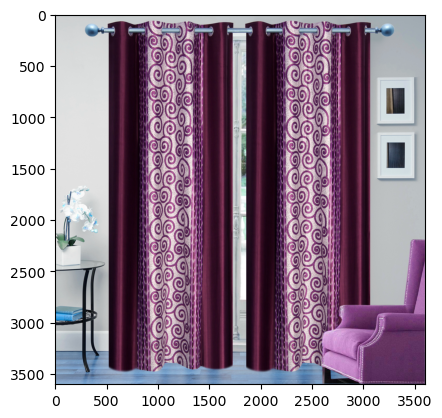

In [85]:
img = cv2.imread(img_path[0])
plt.imshow(img)

In [617]:
time1 = time.time()

image_descripteur = []
image_descripteur_org = []
for idx,image_file in enumerate(img_path) :
    #print('cpt = ',cpt)
    # Loading the image
    img = cv2.imread(image_file)
    
    img = cv2.resize(img, (500, 500))
    # Converting image to grayscale
    gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Utilisez img au lieu de img_

    # Applying SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    key_points , descripteurs = sift.detectAndCompute(gray,None)

    # Marking the keypoint on the image using circles
    img=cv2.drawKeypoints(gray ,
                          kp ,
                          img ,
                          flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    try : 
        
        descripteurs_norm = np.linalg.norm(descripteurs, axis=1, keepdims=True)
        descripteurs_normalises = descripteurs / descripteurs_norm
    except : 
        descripteurs_normalises = 0
    
    # Seuillage des valeurs des vecteurs de descripteurs
    seuil = 0.2
    descripteurs_seuilles = np.minimum(descripteurs_normalises, seuil)
    image_descripteur_org.append(descripteurs)
    image_descripteur.append(descripteurs_seuilles)
    image_features.append(img.flatten()) 
    #image_kp.append([key.pt for key in key_points])

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :         40608.39 secondes


In [618]:
len(image_descripteur)

1050

In [611]:
len(image_descripteur)

3150

In [543]:
image_descripteur[1].shape
des = np.zeros((1,128))
len(des)

1

In [1002]:
descripteurs = []
for i,des in enumerate(image_descripteur_org):
    try:
        print('i:',i,'___',des.shape[0])
        descripteurs.append(des)
    except:
        print('error')
        des = np.zeros((1,128))
        descripteurs.append(des)

i: 0 ___ 3047
i: 1 ___ 1337
i: 2 ___ 1882
i: 3 ___ 2390
i: 4 ___ 1291
i: 5 ___ 968
i: 6 ___ 755
i: 7 ___ 793
i: 8 ___ 507
i: 9 ___ 1208
i: 10 ___ 422
i: 11 ___ 712
i: 12 ___ 772
i: 13 ___ 813
i: 14 ___ 231
i: 15 ___ 368
i: 16 ___ 75
i: 17 ___ 179
i: 18 ___ 807
i: 19 ___ 252
i: 20 ___ 994
i: 21 ___ 866
i: 22 ___ 857
i: 23 ___ 923
i: 24 ___ 1135
i: 25 ___ 963
i: 26 ___ 1791
i: 27 ___ 651
i: 28 ___ 505
i: 29 ___ 401
i: 30 ___ 406
i: 31 ___ 797
i: 32 ___ 815
i: 33 ___ 904
i: 34 ___ 1252
i: 35 ___ 1838
i: 36 ___ 450
i: 37 ___ 921
i: 38 ___ 233
i: 39 ___ 611
i: 40 ___ 272
i: 41 ___ 2712
i: 42 ___ 130
i: 43 ___ 1351
i: 44 ___ 54
i: 45 ___ 1166
i: 46 ___ 571
i: 47 ___ 133
i: 48 ___ 471
i: 49 ___ 664
i: 50 ___ 558
i: 51 ___ 281
i: 52 ___ 677
i: 53 ___ 121
i: 54 ___ 121
i: 55 ___ 121
i: 56 ___ 85
i: 57 ___ 361
i: 58 ___ 301
i: 59 ___ 848
i: 60 ___ 1125
i: 61 ___ 300
i: 62 ___ 961
i: 63 ___ 3294
i: 64 ___ 481
i: 65 ___ 989
i: 66 ___ 282
i: 67 ___ 1118
i: 68 ___ 439
i: 69 ___ 609
i: 70 ___ 188
i: 

In [1003]:
descripteurs = np.concatenate(descripteurs,axis=0)
descripteurs.shape

(963812, 128)

In [1004]:
X

array([[-0.27042737, -0.31066147, -0.8022868 , ..., -0.28279703,
         0.63788103,  0.        ],
       [-0.17897591,  0.52659075, -0.59704897, ..., -0.63213034,
         0.03725218,  0.        ],
       [-0.2595993 ,  1.97987534,  1.34342163, ..., -0.86713592,
        -0.62640358,  0.        ],
       ...,
       [-0.09760674, -0.42199632, -0.29997934, ...,  0.0210689 ,
         0.54271673,  0.        ],
       [-0.27042737, -1.04453792,  1.25045827, ..., -0.86713592,
         0.91720953,  0.        ],
       [ 0.36575736, -0.90806006, -0.38857587, ..., -0.02335625,
         1.19814067,  0.        ]])

In [1001]:
descripteurs[1051]

3.0

In [1005]:
from sklearn import cluster, metrics
import math

time1 = time.time()

#k = int(round(math.sqrt(len(descripteurs)),0))
k = 80
print('nombre de clusters : ',k)
cls = cluster.MiniBatchKMeans(n_clusters=k,random_state=0, init_size=3*k)
cls.fit(descripteurs)


duration1=time.time()-time1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

nombre de clusters :  80


C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


temps de T-SNE :            14.20 secondes


In [927]:
cls.cluster_centers_.shape

(40, 128)

In [928]:
cls.labels_.min(),cls.labels_.max()

(0, 39)

In [930]:
cls.n_clusters

40

In [946]:
def buil_histogram(kmeans,descripteur):
    try:
        des_pred = kmeans.predict(descripteur)
        nb_des = len(descripteur)

        val, _ = np.histogram(des_pred,bins = np.arange(cls.n_clusters))
        return val/nb_des

    except:
        print('erreur histogramme')
        return np.zeros(len(kmeans.cluster_centers_))

histogram_descripteurs = []

In [947]:
len(image_descripteur_org),cls.n_clusters,len(cls.cluster_centers_)

(1050, 80, 80)

In [948]:
import time

t0 = time.time()

for i in range(len(image_descripteur_org)):
    des = np.array(image_descripteur_org[i],dtype = np.float64)
    histogram_descripteurs.append(buil_histogram(cls,des))
    print(i)
    
time = time.time() - t0

print(f'temps d execution : {time}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [949]:
df_feat = pd.DataFrame(histogram_descripteurs).fillna(0)

In [950]:
from sklearn import manifold, decomposition

print(histogram_descripteurs[0].shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(df_feat)
print(feat_pca.shape)

(79,)
(1050, 66)


In [951]:
np.array(image_features).shape

(3493, 750000)

In [952]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :            14.20 secondes


In [953]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label"]
df_tsne['class'].unique()

array([3, 0, 5, 4, 1, 2])

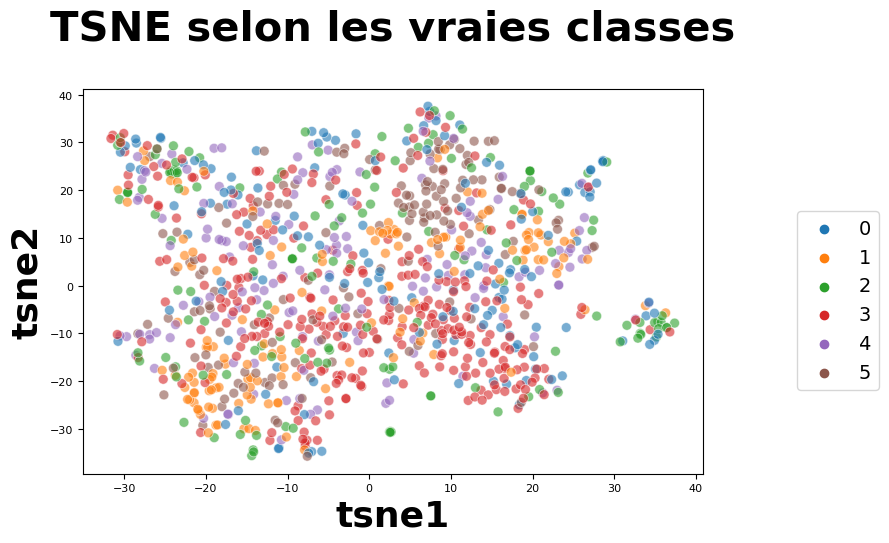

In [954]:

plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

In [842]:
cls.cluster_centers_.shape

(500, 128)

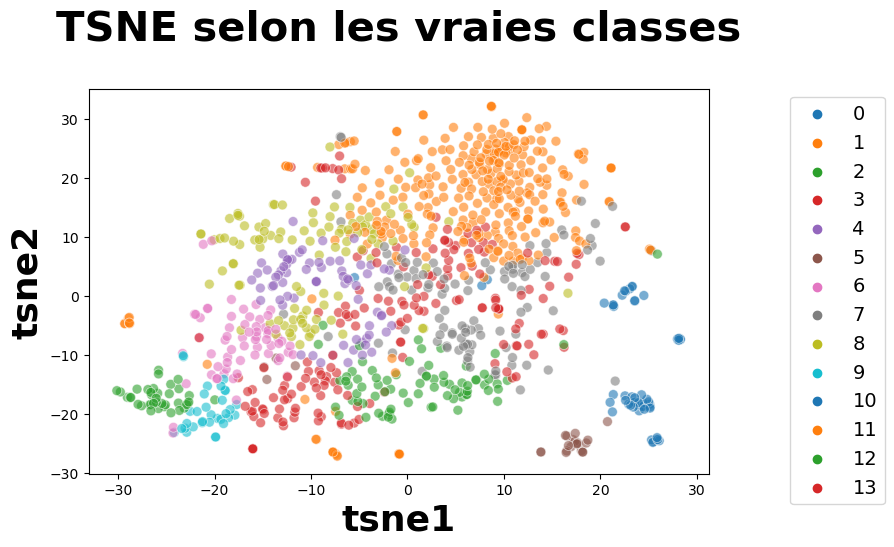

In [50]:

plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="cluster",
                palette=sns.color_palette('tab10', n_colors=14), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

In [923]:
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [965]:
model = SVC()

Scaller = StandardScaler()

X = df_feat
y = df.label

X = Scaller.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array([list(x) for x in X_train])


model.fit(X_train,y_train)
y_pred = model.predict(X_test)

score = model.score(X_test,y_test)     
print(f" score = {round(score,2)} ")



 score = 0.51 


In [1009]:
len(image_descripteur_org[0])

3047

In [1029]:
# test de prédiction 
test = np.array(image_descripteur_org[104],dtype = np.float64)
predictions = cls.predict(test)
pred,_ = np.histogram(predictions, bins=np.arange(cls.n_clusters +1)/len(image_descripteur_org[1030]))

result = model.predict(pred.reshape(1,-1))
print(f'categorie de image : {df.label[104]}, resultat prediction : {result}')

categorie de image : 3, resultat prediction : [0]


In [958]:
t0 = time.time()

pipe = Pipeline([
                ("estimator",LogisticRegression())
                ])
pipe


X = df_feat
y = df.label


param_grid = {
              'estimator':[RandomForestClassifier(),
                           AdaBoostClassifier(),
                           GradientBoostingClassifier(),
                           ExtraTreesClassifier(),
                           DecisionTreeClassifier(),
                           SVC(),
                           BaggingClassifier(),
                           KNeighborsClassifier(13),
                           LogisticRegression()
                          ]}


grid = GridSearchCV(pipe,param_grid=param_grid, cv=5,return_train_score=True ,n_jobs=-1, verbose=1)

grid.fit(X,y)

grid_cv = pd.DataFrame(grid.cv_results_)

new_cols = [i for i in grid_cv.columns if 'split' not in i.lower()]

duration1=time.time() - t0
print("temps : ", "%15.2f" % duration1, "secondes")

grid_cv.loc[:,new_cols].sort_values('mean_test_score', ascending=False)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
temps :            24.14 secondes


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      12.053168      0.212722         0.005386        0.001011   
0       0.963190      0.074809         0.026797        0.001162   
3       0.517798      0.045767         0.031002        0.004427   
5       0.131597      0.014525         0.066801        0.013047   
6       0.608198      0.085502         0.006008        0.000622   
7       0.005398      0.000489         0.024801        0.004665   
1       0.728396      0.073720         0.024801        0.005154   
4       0.104999      0.018709         0.003199        0.000399   
8       0.048200      0.001722         0.003999        0.002000   

                        param_estimator  \
2          GradientBoostingClassifier()   
0              RandomForestClassifier()   
3                ExtraTreesClassifier()   
5                                 SVC()   
6                   BaggingClassifier()   
7  KNeighborsClassifier(n_neighbors=13)   
1                  AdaBoostClassifier()   
4              DecisionTreeClassifier()   
8                  LogisticRegression()   

                                              params  mean_test_score  \
2        {'estimator': GradientBoostingClassifier()}         0.520952   
0            {'estimator': RandomForestClassifier()}         0.510476   
3              {'estimator': ExtraTreesClassifier()}         0.508571   
5                               {'estimator': SVC()}         0.504762   
6                 {'estimator': BaggingClassifier()}         0.458095   
7  {'estimator': KNeighborsClassifier(n_neighbors...         0.426667   
1                {'estimator': AdaBoostClassifier()}         0.384762   
4            {'estimator': DecisionTreeClassifier()}         0.372381   
8                {'estimator': LogisticRegression()}         0.289524   

   std_test_score  rank_test_score  mean_train_score  std_train_score  
2        0.054428                1          0.999524         0.000583  
0        0.032632                2          1.000000         0.000000  
3        0.044508                3          1.000000         0.000000  
5        0.036639                4          0.719762         0.011775  
6        0.015765                5          0.987857         0.002955  
7        0.027537                6          0.522619         0.013657  
1        0.030625                7          0.565238         0.011203  
4        0.029106                8          1.000000         0.000000  
8        0.006999                9          0.295000         0.002542

### Extraction de features CNN

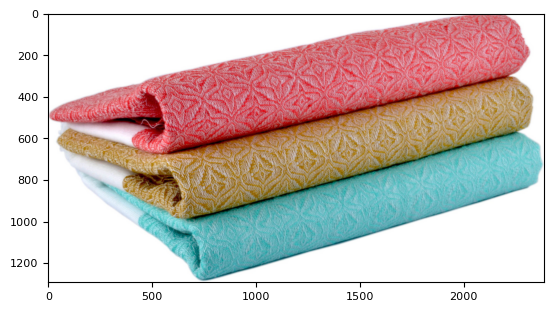

In [1033]:
from matplotlib.image import imread

image = imread(img_path[1])
plt.imshow(image)

In [1034]:
base_model = VGG16()

model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [1037]:
images_features = []
i=0 
t0 = time.time()

for image_file in img_path :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model
    
duration1=time.time() - t0
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")
images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\Dragomir\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
temps de T-SNE :           393.51 secondes


(1050, 4096)

### PCA

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


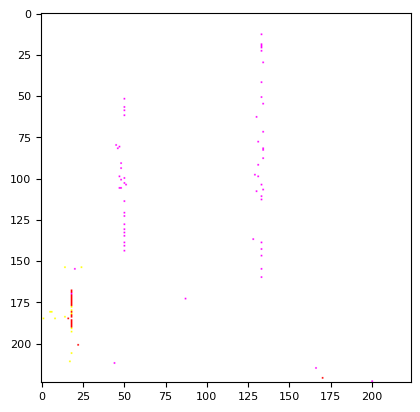

In [1040]:
image = load_img(img_path[0], target_size=(224, 224))
image = img_to_array(image) 
plt.imshow(image)

In [1041]:
image = load_img(img_path[10], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
print(image.shape)
image = preprocess_input(image)
len(image.flatten())

(1, 224, 224, 3)


150528

In [1042]:
image = load_img(img_path[10], target_size=(224, 224))
image = img_to_array(image) 
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)
pred_ = base_model.predict(image, verbose=0)
decode_predictions(
    pred_,top=10
)

[[('n02708093', 'analog_clock', 0.503198),
  ('n03706229', 'magnetic_compass', 0.123264834),
  ('n03197337', 'digital_watch', 0.07970493),
  ('n04579432', 'whistle', 0.06634367),
  ('n04328186', 'stopwatch', 0.06553949),
  ('n04548280', 'wall_clock', 0.022227084),
  ('n02794156', 'barometer', 0.016096195),
  ('n03196217', 'digital_clock', 0.015629662),
  ('n03062245', 'cocktail_shaker', 0.010558986),
  ('n04141975', 'scale', 0.009799443)]]

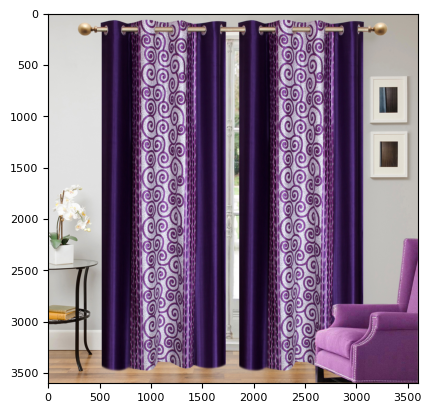

In [1043]:
test = imread(img_path[0])
plt.imshow(test)

In [1044]:
base_model.inputs
base_model.layers[-2].output

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'fc2')>

In [1045]:
img_path[0]

'Source/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

In [1046]:
#image = tf.image.decode_png(img_path[0])

In [1047]:
test = images_features[0]

In [1048]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


In [1049]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\Dragomir\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :            11.68 secondes


In [1050]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["label"]
df_tsne['class'].unique()

array([3, 0, 5, 4, 1, 2])

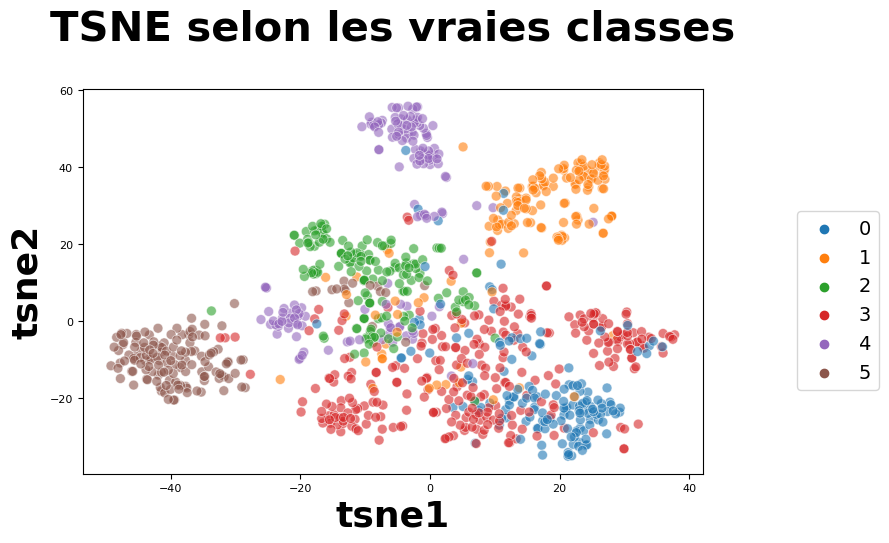

In [1053]:


plt.figure(figsize=(8,5))
sns.scatterplot(
                x="tsne1",
                y="tsne2",
                hue="class",
                palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
                data=df_tsne,
                legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()


In [1054]:
len(X_tsne[1])

2

In [1057]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=6, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=6, n_init=100)

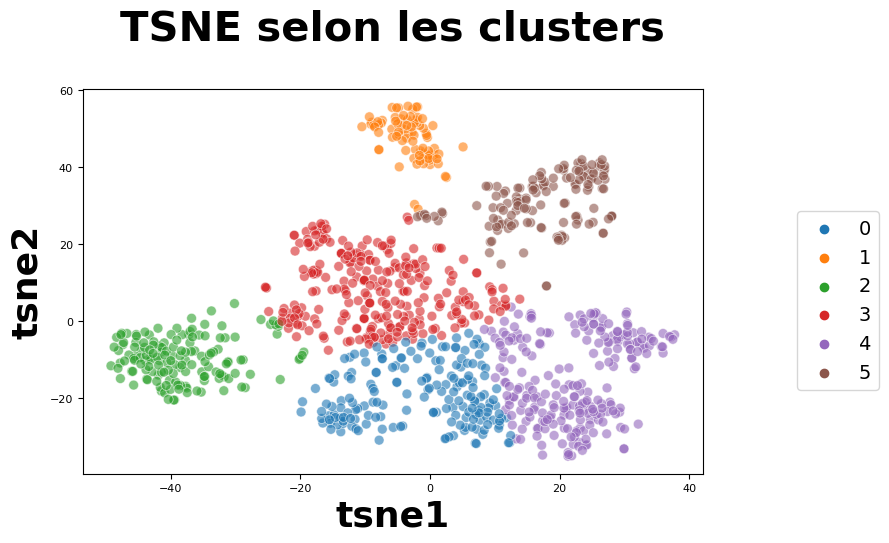

ARI :  0.4379649143809696


In [1058]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14},loc = 'right',bbox_to_anchor=(0.8, 0.2, 0.5, 0.5)) 

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [1059]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 19   2   0   9 116   4]
 [ 11   1   1  16   3 118]
 [  4   0   1 144   1   0]
 [144   0   4  33 116   3]
 [  2  79  11  47   0  11]
 [  1   0 134  15   0   0]]


In [1060]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [1061]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [3 4 5 2 0 1]
              precision    recall  f1-score   support

           0       0.49      0.77      0.60       150
           1       0.87      0.79      0.83       150
           2       0.55      0.96      0.70       150
           3       0.80      0.48      0.60       300
           4       0.96      0.53      0.68       150
           5       0.89      0.89      0.89       150

    accuracy                           0.70      1050
   macro avg       0.76      0.74      0.72      1050
weighted avg       0.76      0.70      0.70      1050



In [1065]:
list_labels = df.category_name.unique()
list_labels
nb_classe = np.arange(0,6)
nb_classe

array([0, 1, 2, 3, 4, 5])

<AxesSubplot:>

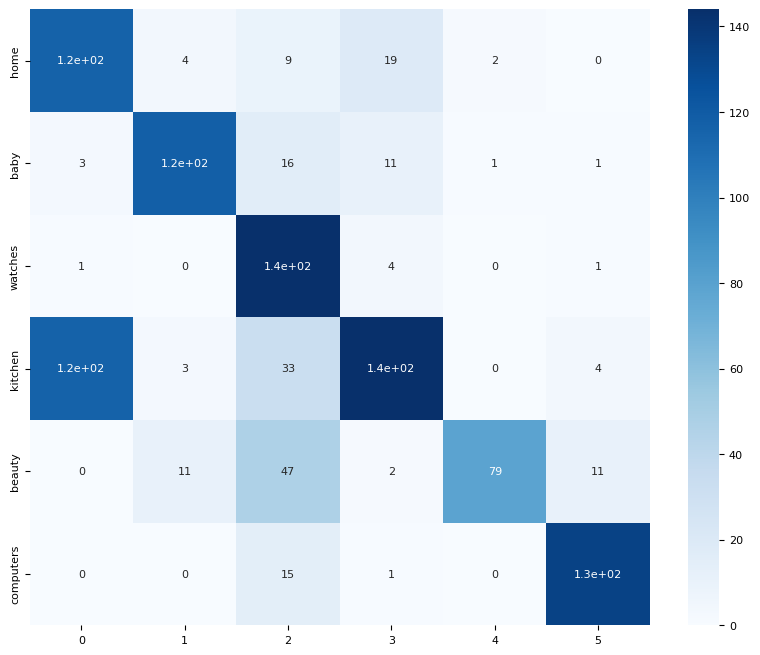

In [1066]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in nb_classe])
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [1067]:
X_tsne[0].reshape(1,-1)

array([[26.454573 , -1.4641618]], dtype=float32)

In [1068]:
cls.labels_

array([4, 0, 0, ..., 4, 4, 4])

In [ ]:
# Les 4 premières sessions de fidle
# la data aumentation (focus) sans moindre 